In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hide Warnings
import warnings
warnings.filterwarnings('ignore')

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.6f}')
pd.set_option('display.expand_frame_repr', False)

# Modelling and Evaluation Tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline  # For creating ML pipelines
from sklearn.compose import ColumnTransformer  # For applying transformations to specific columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc

# Additional Tools
from sklearn.calibration import CalibratedClassifierCV  # For calibrating Decision Tree probabilities

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/liver_disease_data.csv')
df.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,58,Male,35.857584,17.272828,No,Medium,0.658940,No,No,42.734240,Positive
1,71,Female,30.732470,2.201266,No,Medium,1.670557,Yes,No,67.309822,Positive
2,48,Male,19.971407,18.500944,No,Low,9.928308,No,No,63.738956,Negative
3,34,Female,16.615417,12.632870,No,Low,5.630129,No,No,64.555873,Positive
4,62,Female,16.065830,1.087815,No,Medium,3.566218,Yes,No,77.868689,Positive


**Data Pre-processing**

In [ ]:
# Separate features and target
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis'].map({'Negative': 0, 'Positive': 1})

# Identify columns
numeric_cols = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'LiverFunctionTest']
ordinal_cols = ['GeneticRisk']  # Ordinal categorical
nominal_cols = ['Gender', 'Smoking', 'Diabetes', 'Hypertension']  # Nominal categorical

# Define the order for ordinal encoding
genetic_risk_order = ['Low', 'Medium', 'High']

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(categories=[genetic_risk_order]))])
nominal_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('ord', ordinal_transformer, ordinal_cols),
    ('nom', nominal_transformer, nominal_cols)
])

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVC": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier()
}

**Classification Modelling**

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
for name, classifier in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')

    print(name)
    print(f'F1 Score: {f1:.2f}')
    print(classification_report(y_test, y_pred))
    print('-' * 60)

Logistic Regression
F1 Score: 0.81
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       162
           1       0.80      0.85      0.82       178

    accuracy                           0.81       340
   macro avg       0.81      0.81      0.81       340
weighted avg       0.81      0.81      0.81       340

------------------------------------------------------------
Decision Tree
F1 Score: 0.84
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       162
           1       0.82      0.89      0.85       178

    accuracy                           0.84       340
   macro avg       0.84      0.84      0.84       340
weighted avg       0.84      0.84      0.84       340

------------------------------------------------------------
SVC
F1 Score: 0.87
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       162
           1       0.85      0.9

**Model Evaluation using ROC Curve**

Logistic Regression - Optimal Cut Value (Threshold): 0.5613
Decision Tree - Optimal Cut Value (Threshold): 1.0000
SVC - Optimal Cut Value (Threshold): 0.5964
Naive Bayes - Optimal Cut Value (Threshold): 0.4919
Random Forest - Optimal Cut Value (Threshold): 0.5800


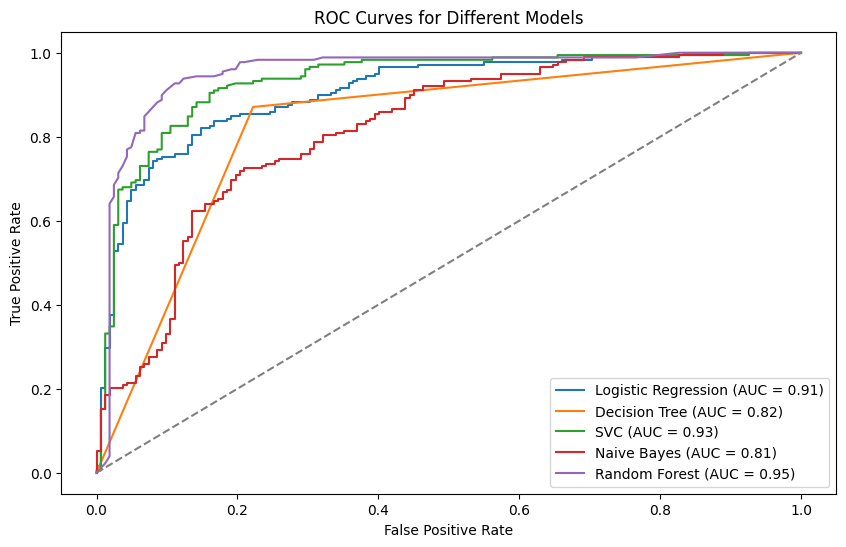

In [ ]:
# Store ROC curve details for plotting
plt.figure(figsize=(10, 6))

for name, classifier in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train)
    y_probs = pipeline.predict_proba(X_test)[:, 1]  # Get probability scores

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Find Optimal Cut Value (OCV)
    sensitivity = tpr
    specificity = 1 - fpr
    ocv_index = np.argmin(np.abs(sensitivity - specificity))
    ocv_threshold = thresholds[ocv_index]

    print(f'{name} - Optimal Cut Value (Threshold): {ocv_threshold:.4f}')

    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Finalize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()

The Random Forest model demonstrated the highest accuracy and AUC score among the evaluated models. Therefore, it is considered the most reliable model for classification of Liver Disease.
However, the Optimal Cut Value for Decision Tree turned out to be 1, which is suspicious because it means the model diagnoses all the patients as negative in having Liver Disease, which is a high risk for misclassification in the medical field. This issue should be fixed immediately to avoid severe consequences of getting False Negatives.

**Model Calibration**

Logistic Regression - Optimal Cut Value (Threshold): 0.5613
Decision Tree - Optimal Cut Value (Threshold): 0.5725
SVM - Optimal Cut Value (Threshold): 0.5971
Naive Bayes - Optimal Cut Value (Threshold): 0.4919
Random Forest - Optimal Cut Value (Threshold): 0.5900


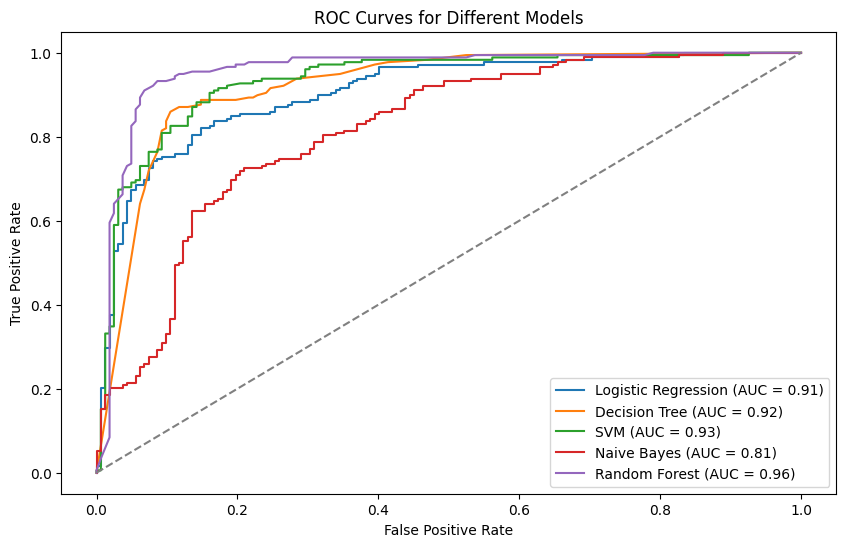

In [ ]:
# Define models with calibrated probabilities for Decision Tree
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": CalibratedClassifierCV(DecisionTreeClassifier(), method='sigmoid'),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier()
}

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
plt.figure(figsize=(10, 6))
for name, classifier in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)

    # F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Get probabilities for ROC
    y_probs = pipeline.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Find Optimal Cut Value (OCV)
    sensitivity = tpr
    specificity = 1 - fpr
    ocv_index = np.argmin(np.abs(sensitivity - specificity))
    ocv_threshold = thresholds[ocv_index]

    print(f'{name} - Optimal Cut Value (Threshold): {ocv_threshold:.4f}')

    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Finalize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()

**Check for Overfitting**

In [ ]:
# Train and evaluate models with both training and test data
for name, classifier in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Get predictions for both training and testing data
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Calculate F1 Score for both train and test sets
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    # Print F1 Scores for train and test
    print(f'{name} - Train F1 Score: {f1_train:.2f}')
    print(f'{name} - Test F1 Score: {f1_test:.2f}')

    # Check if there's a significant difference between train and test F1 scores
    if f1_train - f1_test > 0.1:
        print(f"Warning: {name} may be overfitting! Train F1 score is much higher than Test F1 score.")
    else:
        print(f"{name} appears to generalize well.")
    print('\n')

Logistic Regression - Train F1 Score: 0.83
Logistic Regression - Test F1 Score: 0.81
Logistic Regression appears to generalize well.


Decision Tree - Train F1 Score: 1.00
Decision Tree - Test F1 Score: 0.87


SVM - Train F1 Score: 0.89
SVM - Test F1 Score: 0.87
SVM appears to generalize well.


Naive Bayes - Train F1 Score: 0.72
Naive Bayes - Test F1 Score: 0.74
Naive Bayes appears to generalize well.


Random Forest - Train F1 Score: 1.00
Random Forest - Test F1 Score: 0.91
Random Forest appears to generalize well.




Decision Tree seems to be overfitting and Random Forest is on the verge of overfitting. The hyperparameters of the models shall be tuned to fix this issue.

**Hyperparameter Tuning on Decision Tree and Random Forest to handle Overfitting**

In [ ]:
# Define models with hyperparameters to control overfitting
models = {
    "Decision Tree": CalibratedClassifierCV(DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=4), method='sigmoid'),  # Limiting depth and splits
    "Random Forest": RandomForestClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=4, n_estimators=100)  # Limiting depth and splits, adding number of trees
}

# Split data (already done in previous code)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models with both training and test data
for name, classifier in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Get predictions for both training and testing data
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Calculate F1 Score for both train and test sets
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    # Print F1 Scores for train and test
    print(f'{name} - Train F1 Score: {f1_train:.2f}')
    print(f'{name} - Test F1 Score: {f1_test:.2f}')

    # Classification report
    print(f'Classification Report (Test):\n{classification_report(y_test, y_test_pred)}')
    print('-' * 60)

    # Check if there's a significant difference between train and test F1 scores
    if f1_train - f1_test > 0.1:
        print(f"Warning: {name} may be overfitting! Train F1 score is much higher than Test F1 score.")
    else:
        print(f"{name} appears to generalize well.")
    print('\n')

Decision Tree - Train F1 Score: 0.89
Decision Tree - Test F1 Score: 0.85
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       162
           1       0.86      0.86      0.86       178

    accuracy                           0.85       340
   macro avg       0.85      0.85      0.85       340
weighted avg       0.85      0.85      0.85       340

------------------------------------------------------------
Decision Tree appears to generalize well.


Random Forest - Train F1 Score: 0.96
Random Forest - Test F1 Score: 0.91
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       162
           1       0.88      0.96      0.92       178

    accuracy                           0.91       340
   macro avg       0.91      0.91      0.91       340
weighted avg       0.91      0.91      0.91       340

-----------------------------------

# **Miscellaneous Functions**

In [ ]:
def calculate_woe(dataframe, feature, target, positive_label='Positive', negative_label='Negative', smoothing_factor=0.5):
    """
    Calculate Weight of Evidence (WoE) for a given categorical feature and target in a dataset.

    Parameters:
    - dataframe: The input DataFrame.
    - feature: The column name of the feature for which WoE is calculated.
    - target: The column name of the target variable (binary outcome).
    - smoothing_factor: A smoothing factor (default is 0.5) to handle zero values in bins.

    Returns:
    - woe_mapping: A dictionary mapping feature values to their WoE values.
    """
    if pd.api.types.is_numeric_dtype(dataframe[feature]):
        raise ValueError(f"Feature '{feature}' is numeric. WoE calculation is only applicable for categorical features.")

    df = dataframe.copy()
    df['bin'] = df[feature]

    grouped = df.groupby('bin').agg(
        non_events=(target, lambda x: (x == negative_label).sum()),
        events=(target, lambda x: (x == positive_label).sum())
    ).reset_index()

    total_non_events = grouped['non_events'].sum()
    total_events = grouped['events'].sum()

    grouped['proportion_of_non_events'] = (grouped['non_events'] + smoothing_factor) / total_non_events
    grouped['proportion_of_events'] = (grouped['events'] + smoothing_factor) / total_events

    grouped['woe'] = np.log(grouped['proportion_of_non_events'] / grouped['proportion_of_events'])

    return grouped.set_index('bin')['woe'].to_dict(), grouped


def calculate_iv(dataframe, feature, target, positive_label='Positive', negative_label='Negative', smoothing_factor=0.5):
    """
    Calculate Information Value (IV) for a given categorical feature and target in a dataset.

    Parameters:
    - dataframe: The input DataFrame.
    - feature: The column name of the feature for which IV is calculated.
    - target: The column name of the target variable (binary outcome).
    - smoothing_factor: A smoothing factor (default is 0.5) to handle zero values in bins.

    Returns:
    - total_iv: The total Information Value (IV).
    """
    _, grouped = calculate_woe(dataframe, feature, target, positive_label, negative_label, smoothing_factor)

    grouped['iv'] = (grouped['proportion_of_non_events'] - grouped['proportion_of_events']) * grouped['woe']

    return grouped['iv'].sum()

def replace_with_woe(original_dataset, factors, target):
    """
    Replace all categorical feature values in the dataset with their corresponding WoE values.

    Parameters:
    - original_dataset: The input DataFrame.
    - factors: List of categorical features to replace with WoE values.
    - target: The column name of the target variable.

    Returns:
    - woe_dataset: A DataFrame with WoE values.
    """
    woe_dataset = original_dataset.copy()
    for factor in factors:
        if pd.api.types.is_numeric_dtype(woe_dataset[factor]):
            raise ValueError(f"Feature '{factor}' is numeric. WoE replacement is only applicable for categorical features.")
        woe_values, _ = calculate_woe(original_dataset, factor, target)
        woe_dataset[factor] = woe_dataset[factor].map(woe_values)
    return woe_dataset

def iv_summary_table(dataframe, features, target):
    """
    Create a summary table with IV values and their interpretations for each categorical feature.

    Parameters:
    - dataframe: The input DataFrame.
    - features: List of categorical features for which IV is calculated.
    - target: The column name of the target variable.

    Returns:
    - iv_summary_df: A DataFrame summarizing IV values and interpretations.
    """
    iv_summary = {
        'Feature': [],
        'Total_IV': [],
        'Interpretation': []
    }

    for feature in features:
        if pd.api.types.is_numeric_dtype(dataframe[feature]):
            raise ValueError(f"Feature '{feature}' is numeric. IV calculation is only applicable for categorical features.")

        total_iv = calculate_iv(dataframe, feature, target)

        if total_iv < 0.02:
            category = "Not Useful"
        elif 0.02 <= total_iv < 0.1:
            category = "Weak"
        elif 0.1 <= total_iv < 0.3:
            category = "Medium"
        elif 0.3 <= total_iv < 0.5:
            category = "Strong"
        else:
            category = "Suspicious"

        iv_summary['Feature'].append(feature)
        iv_summary['Total_IV'].append(total_iv)
        iv_summary['Interpretation'].append(category)

    return pd.DataFrame(iv_summary)

# **Logistic Regression Model using Weight of Evidence**

In [ ]:
categorical_features = df.drop(columns=['Diagnosis']).select_dtypes(exclude=['number']).columns
# Replacing Categorical Features with their WoE Transformed Values
woe_df = replace_with_woe(df, categorical_features, 'Diagnosis')
woe_df.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,58,0.381243,35.857584,17.272828,0.256172,0.199463,0.658940,0.087773,0.146009,42.734240,Positive
1,71,-0.389456,30.732470,2.201266,0.256172,0.199463,1.670557,-0.555646,0.146009,67.309822,Positive
2,48,0.381243,19.971407,18.500944,0.256172,0.080320,9.928308,0.087773,0.146009,63.738956,Negative
3,34,-0.389456,16.615417,12.632870,0.256172,0.080320,5.630129,0.087773,0.146009,64.555873,Positive
4,62,-0.389456,16.065830,1.087815,0.256172,0.199463,3.566218,-0.555646,0.146009,77.868689,Positive


In [ ]:
iv_summary_table(df, categorical_features, 'Diagnosis')

,Feature,Total_IV,Interpretation
0,Gender,0.146839,Medium
1,Smoking,0.169154,Medium
2,GeneticRisk,0.175169,Medium
3,Diabetes,0.048520,Weak
4,Hypertension,0.127902,Medium


In [ ]:
# Feature Scaling
numeric_features = df.drop(columns=['Diagnosis']).select_dtypes(include=['number']).columns
scaler = StandardScaler()
woe_df[numeric_features] = scaler.fit_transform(woe_df[numeric_features])

# Map the Target Variable
woe_df["Diagnosis"] = woe_df["Diagnosis"].map({"Positive": 1, "Negative": 0})
woe_df.head()

,Age,Gender,BMI,AlcoholConsumption,Smoking,GeneticRisk,PhysicalActivity,Diabetes,Hypertension,LiverFunctionTest,Diagnosis
0,0.431253,0.381243,1.131724,1.292704,0.256172,0.199463,-1.525542,0.087773,0.146009,-0.745107,1
1,1.168351,-0.389456,0.420720,-1.325806,0.256172,0.199463,-1.170119,-0.555646,0.146009,0.323885,1
2,-0.135746,0.381243,-1.072155,1.506075,0.256172,0.080320,1.731169,0.087773,0.146009,0.168559,0
3,-0.929544,-0.389456,-1.537730,0.486565,0.256172,0.080320,0.221042,0.087773,0.146009,0.204093,1
4,0.658052,-0.389456,-1.613973,-1.519255,0.256172,0.199463,-0.504096,-0.555646,0.146009,0.783176,1


F1 Score: 0.82


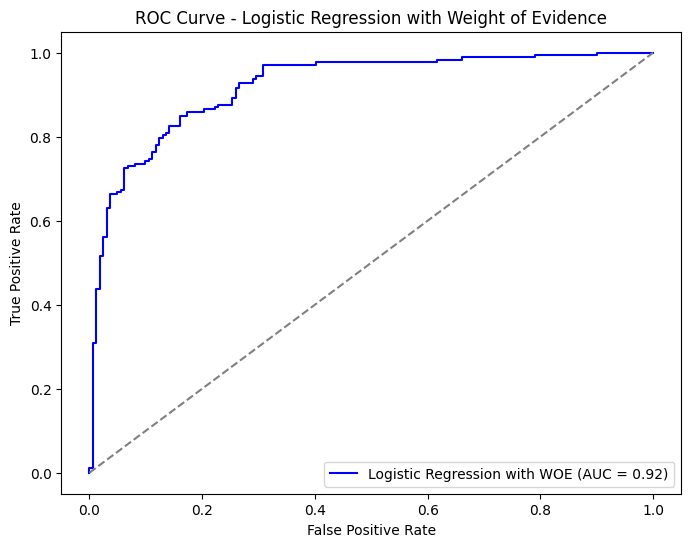

In [ ]:
# Split the data into train and test sets
X = woe_df.drop('Diagnosis', axis=1)
y = woe_df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Accuracy
y_pred = logreg.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1:.2f}')

# Predict probabilities on the test set
y_probs = logreg.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'Logistic Regression with WOE (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line (Random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with Weight of Evidence')
plt.legend(loc='lower right')
plt.show()

# **Logistic Regression using Decision Tree Segments as Inputs**

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Identify categorical and numerical features
categorical_features = ["Gender", "Smoking", "GeneticRisk", "Diabetes", "Hypertension"]
numeric_features = ["Age", "BMI", "AlcoholConsumption", "PhysicalActivity", "LiverFunctionTest"]

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)  # One-hot encode categorical vars
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

# Train a Decision Tree on the Training Data
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

# Extract Leaf Indices for Training and Test Sets
train_leaf_nodes = dt.apply(X_train)
test_leaf_nodes = dt.apply(X_test)

# One-Hot Encode Leaf Nodes Properly
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_leaf_features = encoder.fit_transform(train_leaf_nodes.reshape(-1, 1))
test_leaf_features = encoder.transform(test_leaf_nodes.reshape(-1, 1))

# Combine Processed Features with Leaf Node Features
X_train_combined = np.hstack((X_train, train_leaf_features))
X_test_combined = np.hstack((X_test, test_leaf_features))

# Train Logistic Regression on the Augmented Training Data
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_combined, y_train)

# Evaluate Logistic Regression on Test Data
train_accuracy = lr.score(X_train_combined, y_train)
test_accuracy = lr.score(X_test_combined, y_test)

print(f"Logistic Regression Train Accuracy: {train_accuracy:.2f}")
print(f"Logistic Regression Test Accuracy: {test_accuracy:.2f}")

Logistic Regression Train Accuracy: 0.92
Logistic Regression Test Accuracy: 0.90


# **Model Deployment**

In [ ]:
import joblib
from google.colab import files
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define the Random Forest model with hyperparameters
rf_model = RandomForestClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=4, n_estimators=100, random_state=42)

# Define numerical and categorical columns
numeric_features = ["Age", "BMI", "AlcoholConsumption", "PhysicalActivity", "LiverFunctionTest"]
categorical_features = ["Gender", "Smoking", "GeneticRisk", "Diabetes", "Hypertension"]

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Scale numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ]
)

# Train the Random Forest model
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# Split the data using the original DataFrame 'df'
X = df[numeric_features + categorical_features]  # Select the features for the model
y = df["Diagnosis"].map({"Positive": 1, "Negative": 0})  # Map the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the pipeline to the training data
pipeline_rf.fit(X_train, y_train)

# Save the trained model as a pickle file
joblib.dump(pipeline_rf, "liver_disease_model.pkl")

# Download the file to your local machine (Optional)
files.download("liver_disease_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open("app.py", "w") as f:
    f.write("""import streamlit as st
import joblib
import numpy as np
import pandas as pd

def load_model():
    try:
        return joblib.load("liver_disease_model.pkl")
    except FileNotFoundError:
        st.error("Model file not found. Please ensure 'liver_disease_model.pkl' is in the working directory.")
        return None

# Load trained model
model = load_model()

def user_input():
    st.sidebar.header("Patient Information")
    gender = st.sidebar.selectbox("Gender", ["Male", "Female"])
    age = st.sidebar.number_input("Age", min_value=1, max_value=120, value=30)
    bmi = st.sidebar.number_input("BMI", min_value=10.0, max_value=50.0, value=22.5, step=0.1)
    alcohol = st.sidebar.slider("Alcohol Consumption (units/week)", 0, 20, 10)
    physical = st.sidebar.slider("Physical Activity (hours/week)", 0, 10, 5)
    lft = st.sidebar.number_input("Liver Function Test Score", min_value=20.0, max_value=100.0, value=50.0, step=0.1)
    smoking = st.sidebar.selectbox("Smoking", ["Yes", "No"])
    genetic_risk = st.sidebar.selectbox("Genetic Risk", ["Low", "Medium", "High"])
    diabetes = st.sidebar.selectbox("Diabetes", ["Yes", "No"])
    hypertension = st.sidebar.selectbox("Hypertension", ["Yes", "No"])

    return pd.DataFrame({
        "Age": [age], "BMI": [bmi], "AlcoholConsumption": [alcohol],
        "PhysicalActivity": [physical], "LiverFunctionTest": [lft],
        "Gender": [gender], "Smoking": [smoking], "GeneticRisk": [genetic_risk],
        "Diabetes": [diabetes], "Hypertension": [hypertension]
    })

st.title("🩺 Liver Disease Prediction App")
st.write("Enter patient details in the sidebar to predict the likelihood of liver disease.")

data = user_input()

if model and st.button("Predict"):
    prediction = model.predict(data)[0]
    prob = model.predict_proba(data)[0][1]

    st.subheader("Prediction Result")
    if prediction == 1:
        st.error(f"⚠️ High Risk of Liver Disease! (Probability: {prob:.4f})")
    else:
        st.success(f"✅ Low Risk of Liver Disease (Probability: {prob:.4f})")

    st.write("**Note:** This is a machine learning-based prediction and not a medical diagnosis.")""")

In [ ]:
ls -l app.py

-rw-r--r-- 1 root root 2152 Mar 23 23:22 app.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com

35.194.136.27


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.194.136.27:8501

⠼⠴⠦⠧your url is: https://seven-candies-juggle.loca.lt


In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00
